In [36]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import tqdm
from itertools import combinations


In [38]:
genre_sentiment = pd.read_csv('genre_sentiment_scores.csv')
movie_sentiment = pd.read_csv('movie_sentiment_scores.csv')
rating_vs_sentiment = pd.read_csv('movie_ratings_vs_sentiments.csv')
reviews = pd.read_csv('sampled_reviews.csv')

scores = pd.read_csv('grouplens_data/ml-latest/genome-scores.csv')
tags = pd.read_csv('grouplens_data/ml-latest/genome-tags.csv')
links = pd.read_csv('grouplens_data/ml-latest/links.csv')
movies = pd.read_csv('grouplens_data/ml-latest/movies.csv')
ratings = pd.read_csv('grouplens_data/ml-latest/ratings.csv')

# movies.set_index("movieId", inplace=True)
# rating_vs_sentiment.set_index("movieId", inplace=True)
# movie_sentiment.set_index("movieId", inplace=True)
# scores.set_index("movieId", inplace=True)
# links.set_index("movieId", inplace=True)





In [ ]:
# Assuming all the DataFrames are already loaded

# Merge the relevant data into a single DataFrame by `movieId`
nested_df = pd.merge(movies, movie_sentiment, on="movieId", how="left")

In [ ]:
nested_df = pd.merge(nested_df, rating_vs_sentiment, on="movieId", how="left", suffixes=("", "_rating"))


In [ ]:
nested_df = pd.merge(nested_df, links, on="movieId", how="left")


In [ ]:
nested_df = nested_df[nested_df['average_sentiment'].notna()]

In [ ]:
ratings = ratings[ratings['movieId'].isin(nested_df['movieId'])]


In [ ]:
reviews = reviews[reviews['movieId'].isin(nested_df['movieId'])]

In [ ]:
scores = scores[scores['movieId'].isin(nested_df['movieId'])]

In [ ]:
ratings_nested = ratings.groupby('movieId').apply(lambda x: x[['userId', 'rating', 'timestamp']].to_dict(orient='records')).reset_index(name='ratings')


/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_23312/2434976666.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ratings_nested = ratings.groupby('movieId').apply(lambda x: x[['userId', 'rating', 'timestamp']].to_dict(orient='records')).reset_index(name='ratings')


In [ ]:
reviews_nested = reviews.groupby('movieId').apply(lambda x: x[['review']].to_dict(orient='records')).reset_index(name='reviews')

/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_23312/1395610327.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reviews_nested = reviews.groupby('movieId').apply(lambda x: x[['review']].to_dict(orient='records')).reset_index(name='reviews')


In [ ]:
tags_nested = scores.merge(tags, on='tagId').groupby('movieId').apply(lambda x: x[['tag', 'relevance']].to_dict(orient='records')).reset_index(name='tags')


/var/folders/06/l7w93lb13l7f94htvwv84z2c0000gn/T/ipykernel_23312/2480635341.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tags_nested = scores.merge(tags, on='tagId').groupby('movieId').apply(lambda x: x[['tag', 'relevance']].to_dict(orient='records')).reset_index(name='tags')


In [ ]:
nested_df = pd.merge(nested_df, ratings_nested, on="movieId", how="left")


In [ ]:
nested_df = pd.merge(nested_df, reviews_nested, on="movieId", how="left")


In [ ]:
nested_df = pd.merge(nested_df, tags_nested, on="movieId", how="left")


In [ ]:
nested_df = nested_df[['movieId', 'title', 'genres', 'average_sentiment', 'ratings', 'reviews', 'tags','average_rating']]


1. Movie-Movie Similarity Network
Nodes: Movies
Edges: Similarity between movies based on shared genres, tags, sentiments, or ratings.

Attributes:

Node Attributes:
average_sentiment
average_rating
genres
tags (from tags and scores DataFrames)
Edge Attributes:
genre_overlap: Number of shared genres
tag_similarity: Sum of relevance scores for shared tags
sentiment_difference: Absolute difference in average sentiments
rating_difference: Absolute difference in average ratings
Construction Details:

Genre Similarity: Create edges between movies that share at least one genre. Weight the edges by the number of shared genres.
Tag Similarity: Use the scores and tags DataFrames to find shared tags between movies. Weight the edges by the cumulative relevance scores of shared tags.
Sentiment and Rating Similarity: Adjust edge weights based on how close movies are in sentiment and rating scores.
Potential Questions:

Community Detection: What clusters of movies emerge based on shared genres and tags?
Analysis: Use algorithms like Louvain or Girvan-Newman to detect communities.
Sentiment Analysis: Are there clusters of movies with similar sentiments and ratings?
Analysis: Examine if high-sentiment movies cluster together and how they relate to genres and tags.
Genre Influence: How do genres influence the clustering of movies?
Analysis: Investigate if certain genres are central within clusters.

In [ ]:
G = nx.Graph()



In [ ]:
# filtered_movies = rating_vs_sentiment[rating_vs_sentiment['rating_count'] > 30000]
# filtered_movie_ids = set(filtered_movies['movieId'])


In [ ]:
for _, row in nested_df.iterrows():
    # if row['movieId'] in filtered_movie_ids:
    G.add_node(
        f"movie_{row['movieId']}",
        type="movie",
        title=row['title'],
        genres=row['genres'].split('|'),  # Split genres into a list
        average_sentiment=row['average_sentiment'],  # Placeholder
        average_rating=None  # Placeholder
    )


In [ ]:
# Add sentiment
for _, row in movie_sentiment.iterrows():
    movie_node = f"movie_{row['movieId']}"
    if G.has_node(movie_node):
        G.nodes[movie_node]['average_sentiment'] = row['average_sentiment']

# Add rating
for _, row in rating_vs_sentiment.iterrows():
    movie_node = f"movie_{row['movieId']}"
    if G.has_node(movie_node):
        G.nodes[movie_node]['average_rating'] = row['average_rating']


In [ ]:
def genre_overlap(movie1_genres, movie2_genres):
    return len(set(movie1_genres).intersection(set(movie2_genres)))


In [ ]:
def tag_similarity(movie1, movie2, scores_df):
    tags1 = scores_df[scores_df['movieId'] == movie1]
    tags2 = scores_df[scores_df['movieId'] == movie2]
    shared_tags = set(tags1['tagId']).intersection(set(tags2['tagId']))

    # Calculate cumulative relevance for shared tags
    relevance1 = tags1[tags1['tagId'].isin(shared_tags)]['relevance'].sum()
    relevance2 = tags2[tags2['tagId'].isin(shared_tags)]['relevance'].sum()

    return relevance1 + relevance2


In [ ]:
sentiment_threshold = 0.1  # Allowable difference in sentiment
rating_threshold = 0.5    # Allowable difference in rating


In [ ]:
movie_ids = nested_df['movieId'].unique()
print(len(movie_ids) * len(movie_ids))

783225


In [ ]:

for movie1, movie2 in tqdm.tqdm(combinations(movie_ids, 2)):
    node1 = f"movie_{movie1}"
    node2 = f"movie_{movie2}"
    
    # Check if both nodes exist
    if G.has_node(node1) and G.has_node(node2):
        # Get node attributes
        genres1 = G.nodes[node1]['genres']
        genres2 = G.nodes[node2]['genres']
        sentiment1 = G.nodes[node1]['average_sentiment']
        sentiment2 = G.nodes[node2]['average_sentiment']
        rating1 = G.nodes[node1]['average_rating']
        rating2 = G.nodes[node2]['average_rating']
        
        # Calculate similarities
        genre_score = genre_overlap(genres1, genres2)
        # print(genre_score)
        tag_score = tag_similarity(movie1, movie2, scores)
        # print(tag_score)
        if tag_score > 400:
            G.add_edge(node1,node2)

        # # print(sentiment1)
        # # print(sentiment2)
        # # print()
        # sentiment_score = abs(sentiment1 - sentiment2) if sentiment1 and sentiment2 else None
        # rating_score = abs(rating1 - rating2) if rating1 and rating2 else None
        
        # # Check thresholds
        # if genre_score > 0 or tag_score > 0:  # At least some overlap
        #     if (sentiment_score is None or sentiment_score <= sentiment_threshold) and \
        #        (rating_score is None or rating_score <= rating_threshold):
        #         # Add edge
        #         G.add_edge(
        #             node1, node2,
        #             weight=genre_score + tag_score,  # Combined similarity score
        #             genre_overlap=genre_score,
        #             tag_similarity=tag_score,
        #             sentiment_difference=sentiment_score,
        #             rating_difference=rating_score
        #         )


391170it [06:15, 1042.44it/s]


In [ ]:

# for movie1, movie2 in tqdm.tqdm(combinations(movie_ids, 2)):
#     node1 = f"movie_{movie1}"
#     node2 = f"movie_{movie2}"
    
#     # Check if both nodes exist
#     if G.has_node(node1) and G.has_node(node2):
#         # Get node attributes
#         genres1 = G.nodes[node1]['genres']
#         genres2 = G.nodes[node2]['genres']
#         sentiment1 = G.nodes[node1]['average_sentiment']
#         sentiment2 = G.nodes[node2]['average_sentiment']
#         rating1 = G.nodes[node1]['average_rating']
#         rating2 = G.nodes[node2]['average_rating']
        
#         # Calculate similarities
#         genre_score = genre_overlap(genres1, genres2)
#         # print(genre_score)
#         tag_score = tag_similarity(movie1, movie2, scores)
#         # print(tag_score)
#         if tag_score > 400:
#             G.add_edge(node1,node2)

#         # print(sentiment1)
#         # print(sentiment2)
#         # print()
#         sentiment_score = abs(sentiment1 - sentiment2) if sentiment1 and sentiment2 else None
#         rating_score = abs(rating1 - rating2) if rating1 and rating2 else None
        
#         # Check thresholds
#         if genre_score > 0 or tag_score > 0:  # At least some overlap
#             if (sentiment_score is None or sentiment_score <= sentiment_threshold) and \
#                (rating_score is None or rating_score <= rating_threshold):
#                 # Add edge
#                 G.add_edge(
#                     node1, node2,
#                     weight=genre_score + tag_score,  # Combined similarity score
#                     genre_overlap=genre_score,
#                     tag_similarity=tag_score,
#                     sentiment_difference=sentiment_score,
#                     rating_difference=rating_score
#                 )


In [ ]:

# for movie1, movie2 in tqdm.tqdm(combinations(movie_ids, 2)):
#     node1 = f"movie_{movie1}"
#     node2 = f"movie_{movie2}"
    
#     # Check if both nodes exist
#     if G.has_node(node1) and G.has_node(node2):
#         # Get node attributes
#         genres1 = G.nodes[node1]['genres']
#         genres2 = G.nodes[node2]['genres']
#         sentiment1 = G.nodes[node1]['average_sentiment']
#         sentiment2 = G.nodes[node2]['average_sentiment']
#         rating1 = G.nodes[node1]['average_rating']
#         rating2 = G.nodes[node2]['average_rating']
        
#         # Calculate similarities
#         genre_score = genre_overlap(genres1, genres2)
#         # print(genre_score)
#         tag_score = tag_similarity(movie1, movie2, scores)
#         sentiment_score = abs(sentiment1 - sentiment2) if sentiment1 and sentiment2 else None
#         rating_score = abs(rating1 - rating2) if rating1 and rating2 else None
        
#         # Check thresholds
#         if genre_score > 0 or tag_score > 0:  # At least some overlap
#             if (sentiment_score is None or sentiment_score <= sentiment_threshold) and \
#                (rating_score is None or rating_score <= rating_threshold):
#                 # Add edge
#                 G.add_edge(
#                     node1, node2,
#                     weight=genre_score + tag_score,  # Combined similarity score
#                     genre_overlap=genre_score,
#                     tag_similarity=tag_score,
#                     sentiment_difference=sentiment_score,
#                     rating_difference=rating_score
#                 )


In [ ]:
len(G.edges)

29133

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities

communities = greedy_modularity_communities(G)
print(f"Number of Communities: {len(communities)}")


Number of Communities: 157


In [ ]:
centrality = nx.degree_centrality(G)
top_central_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Central Movies:", top_central_nodes)


Top 10 Central Movies: [('movie_2959', 0.824660633484163), ('movie_2329', 0.5882352941176471), ('movie_260', 0.5871040723981901), ('movie_1196', 0.581447963800905), ('movie_79132', 0.5633484162895928), ('movie_527', 0.5475113122171946), ('movie_541', 0.5463800904977376), ('movie_2858', 0.5316742081447964), ('movie_4878', 0.5305429864253394), ('movie_44191', 0.5305429864253394)]


In [ ]:
movies[movies['movieId'] == 260]

,movieId,title,genres
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi


In [ ]:
avg_clustering = nx.average_clustering(G)
print("Average Clustering Coefficient:", avg_clustering)


Average Clustering Coefficient: 0.53323633152866


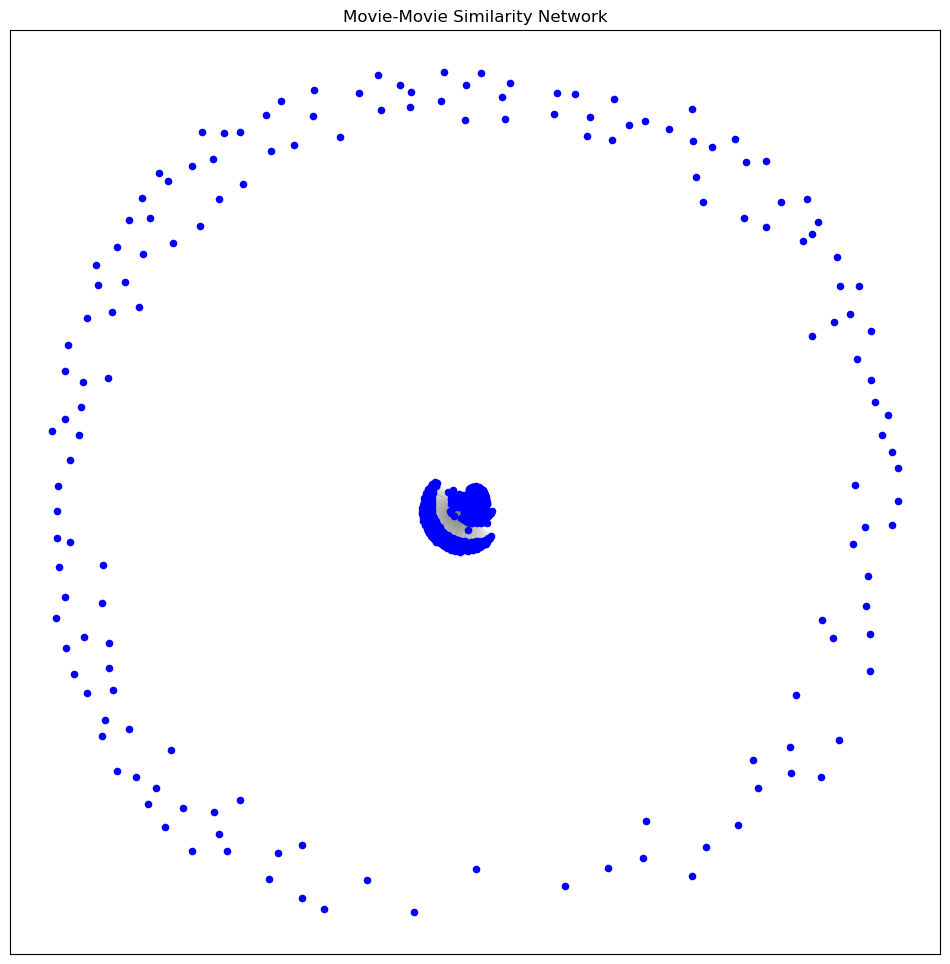

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Spring layout for better aesthetics
nx.draw_networkx_nodes(G, pos, node_size=20, node_color="blue")
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color="gray")
plt.title("Movie-Movie Similarity Network")
plt.show()


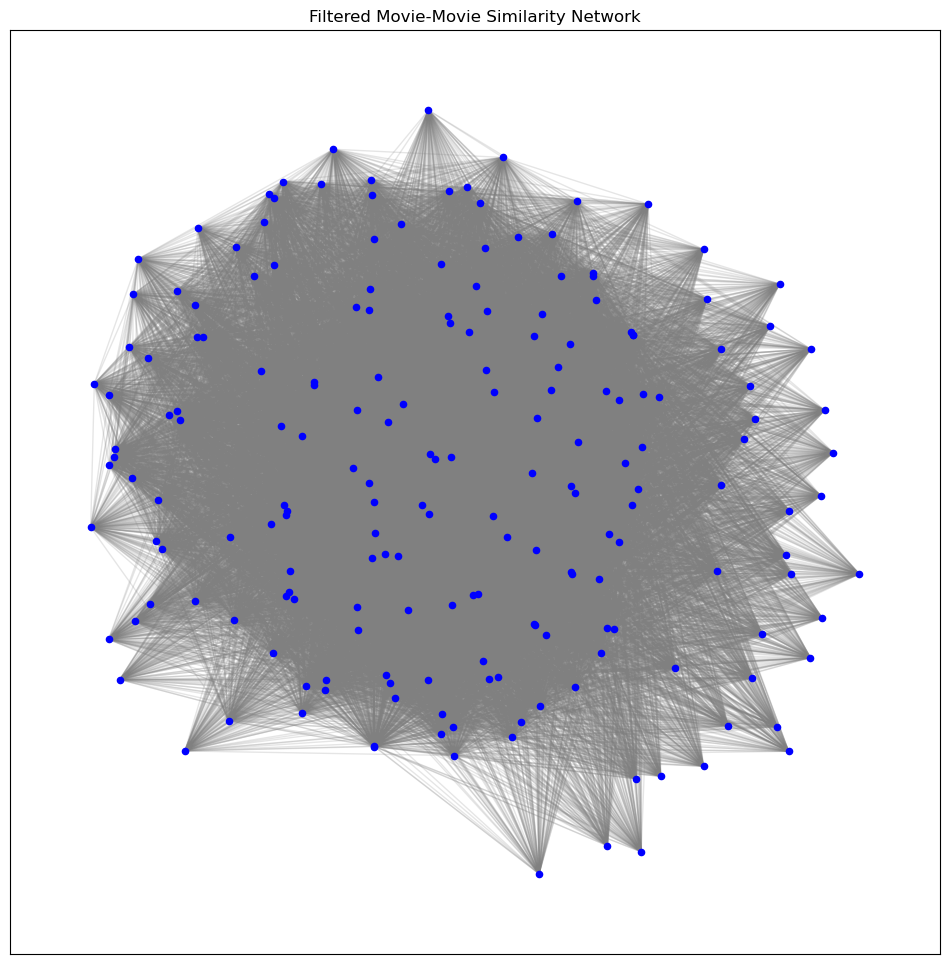

In [ ]:
# Remove nodes with degree less than 2
nodes_to_remove = [node for node, degree in dict(G.degree()).items() if degree < 100]
G.remove_nodes_from(nodes_to_remove)

# Plot the filtered graph
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Spring layout for better aesthetics
nx.draw_networkx_nodes(G, pos, node_size=20, node_color="blue")
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color="gray")
plt.title("Filtered Movie-Movie Similarity Network")
plt.show()


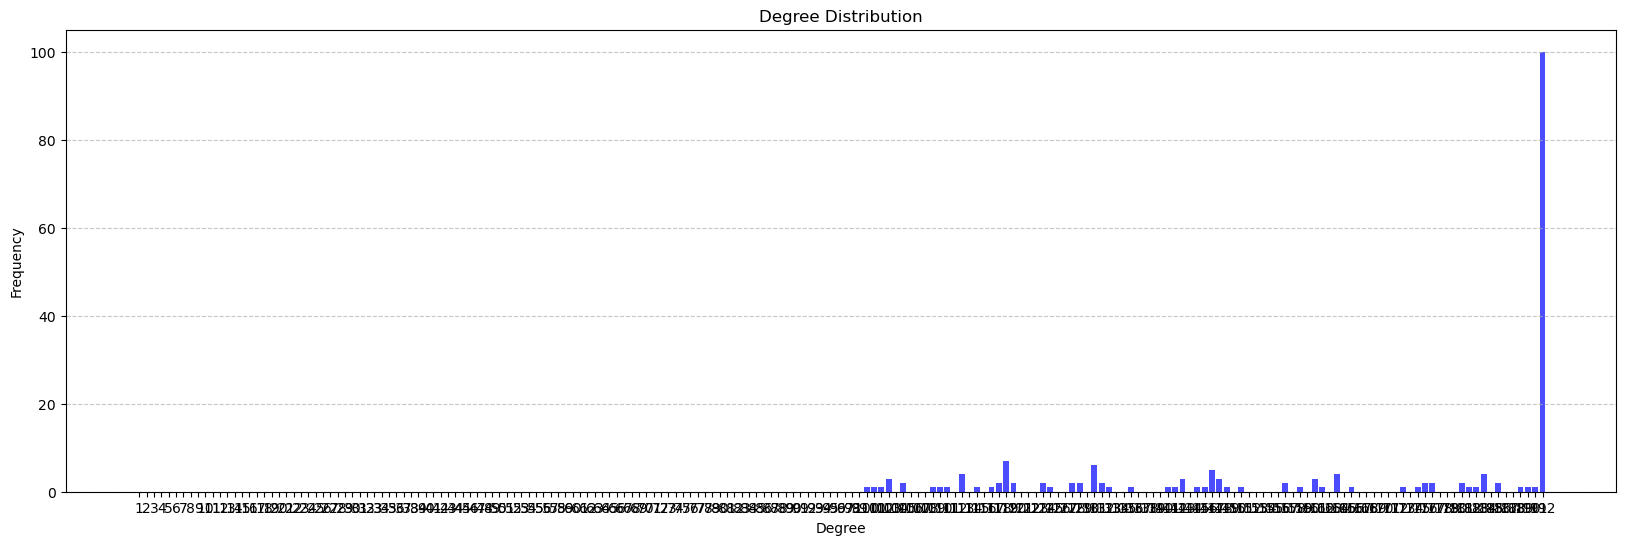

In [ ]:
import matplotlib.pyplot as plt

# Calculate the degree of each node
degree_sequence = [degree for _, degree in G.degree()]

# Plot the degree distribution
plt.figure(figsize=(20, 6))
plt.hist(degree_sequence, bins=range(1, max(degree_sequence) + 2), align='left', rwidth=0.8, color='blue', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.xticks(range(1, max(degree_sequence) + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
